In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math

from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;
import re
from IPython.display import clear_output

In [2]:
list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [3]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,10))

In [4]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    k_best_bids_and_asks = np.zeros(shape = (2,2,k))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        try:
            k_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        except IndexError as err:
            k_best_bids_and_asks[0][counter%2][(counter-1)//2]=0
            print('bid', err, record)
        #ask
        try:
            k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        except IndexError as err:
            k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=0
            print("ask", err, record)        
    return k_best_bids_and_asks

In [5]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [6]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [7]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==record.shape[1]:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [8]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5), for 5 best bids/asks
    if record.shape!=(2,2,10):
        raise Exception('Bad record shape!')
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==record.shape[1]:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [9]:
#### PO co?
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [10]:
def index_to_time(index):
    hour=index//60
    minute=index%60
    return hour+8, minute, 0 
# why minute+1???? was because orderbook[0] was from 8:01
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [11]:
### ADD valueerrors?

def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice #???? bad?
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [12]:
'''def get_order_inbalance(record): #single company
    
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result'''
#uhmmm wrong func???

'def get_order_inbalance(record): #single company\n    \n    timestamps=record.shape[0]\n    result=np.zeros(timestamps)\n    for i in range (0,timestamps):\n        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)\n    return result'

# READ DATA

In [13]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,10))

In [14]:
# read order books into data
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>=0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<30)):
                data[count_comp][count] = get_k_best_offers(elements[1:], k=10)  
                count+=1

ask list index out of range ['BID', '902.5', '306.0', '950.0', '400.0', '997.0', '500.0', '1000.0', '13000.0', '1014.0', '3000.0', '1034.0', '63.0', '1049.0', '3512.0', '1052.0', '315.0', '1054.0', '49.0', '1055.0', '600.0', '1058.0', '500.0', '1064.0', '1000.0', '1110.0', '108.0', '1184.0', '3.0', 'ASK', '1059.0', '1080.0', '1061.0', '600.0', '1063.0', '530.0', '1064.0', '315.0', '1066.0', '354.0', '1077.0', '62.0', '1150.0', '1309.0', '1200.0', '1600.0', '1250.0', '305.0']
ask list index out of range ['BID', '902.5', '306.0', '950.0', '400.0', '997.0', '500.0', '1000.0', '13000.0', '1014.0', '3000.0', '1034.0', '63.0', '1049.0', '3512.0', '1052.0', '315.0', '1054.0', '49.0', '1055.0', '600.0', '1058.0', '500.0', '1064.0', '1000.0', '1110.0', '108.0', '1184.0', '3.0', 'ASK', '1059.0', '1080.0', '1061.0', '600.0', '1063.0', '530.0', '1064.0', '315.0', '1066.0', '354.0', '1077.0', '62.0', '1150.0', '1309.0', '1200.0', '1600.0', '1250.0', '305.0']
ask list index out of range ['BID', '124

ask list index out of range ['BID', '771.0', '2460.0', '816.0', '2320.0', '900.0', '800.0', '919.0', '11870.0', '940.0', '1200.0', '968.0', '1200.0', '970.0', '1500.0', '972.0', '17729.0', '974.5', '509.0', '975.5', '8002.0', '978.0', '6454.0', '985.5', '71.0', '986.5', '389.0', '987.0', '149.0', '987.5', '838.0', 'ASK', '989.0', '337.0', '989.5', '2331.0', '990.0', '902.0', '996.0', '10000.0', '998.0', '1107.0', '999.0', '509.0', '1000.0', '6312.0', '1002.0', '26934.0', '1021.0', '1200.0']
ask list index out of range ['BID', '771.0', '2460.0', '816.0', '2320.0', '900.0', '800.0', '919.0', '11870.0', '940.0', '1200.0', '968.0', '1200.0', '970.0', '1500.0', '972.0', '17729.0', '974.5', '509.0', '975.5', '8002.0', '978.0', '6454.0', '985.5', '71.0', '986.5', '389.0', '987.0', '149.0', '987.5', '838.0', 'ASK', '989.0', '337.0', '989.5', '2331.0', '990.0', '902.0', '996.0', '10000.0', '998.0', '1107.0', '999.0', '509.0', '1000.0', '6312.0', '1002.0', '26934.0', '1021.0', '1200.0']
ask list

ask list index out of range ['BID', '1000.0', '6000.0', '1020.0', '500.0', '1180.0', '1000.0', '1193.0', '2466.0', '1375.0', '125.0', '1383.0', '40.0', '1410.0', '709.0', '1414.0', '173.0', '1473.0', '71.0', '1479.0', '476.0', '1496.0', '1483.0', '1498.0', '29.0', '1499.0', '304.0', '1503.0', '500.0', '1597.0', '4.0', 'ASK', '1504.0', '271.0', '1508.0', '406.0', '1510.0', '29.0', '1511.0', '654.0', '1515.0', '304.0', '1519.0', '1483.0', '1530.0', '476.0', '1536.0', '72.0']
ask list index out of range ['BID', '1000.0', '6000.0', '1020.0', '500.0', '1180.0', '1000.0', '1193.0', '2466.0', '1375.0', '125.0', '1383.0', '40.0', '1410.0', '709.0', '1414.0', '173.0', '1473.0', '71.0', '1479.0', '476.0', '1496.0', '1483.0', '1498.0', '29.0', '1499.0', '304.0', '1503.0', '500.0', '1597.0', '4.0', 'ASK', '1504.0', '271.0', '1508.0', '406.0', '1510.0', '29.0', '1511.0', '654.0', '1515.0', '304.0', '1519.0', '1483.0', '1530.0', '476.0', '1536.0', '72.0']
ask list index out of range ['BID', '1000.0'

ask list index out of range ['BID', '943.5', '218.0', '970.0', '5000.0', '981.0', '2500.0', '988.5', '89.0', '1000.0', '6250.0', '1003.0', '36.0', '1004.0', '418.0', '1005.0', '230.0', '1007.0', '110.0', '1009.0', '828.0', '1011.0', '154.0', '1015.0', '258.0', '1031.0', '109.0', 'ASK', '979.5', '43.0', '991.0', '684.0', '1009.0', '160.0', '1011.0', '36.0', '1017.0', '230.0', '1020.0', '5000.0', '1029.0', '93.0', '1200.0', '415.0']
ask list index out of range ['BID', '943.5', '218.0', '970.0', '5000.0', '981.0', '2500.0', '988.5', '89.0', '1000.0', '6250.0', '1003.0', '36.0', '1004.0', '418.0', '1005.0', '230.0', '1007.0', '110.0', '1009.0', '828.0', '1011.0', '154.0', '1015.0', '258.0', '1031.0', '109.0', 'ASK', '979.5', '43.0', '991.0', '684.0', '1009.0', '160.0', '1011.0', '36.0', '1017.0', '230.0', '1020.0', '5000.0', '1029.0', '93.0', '1200.0', '415.0']
ask list index out of range ['BID', '943.5', '218.0', '970.0', '5000.0', '981.0', '2500.0', '988.5', '89.0', '1000.0', '6250.0', '

ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0', '578.0', '585.5', '8.0', 'ASK', '551.5', '751.0', '553.5', '16.0', '554.0', '1700.0', '554.5', '3986.0', '557.5', '2470.0', '560.0', '181.0', '561.5', '1254.0']
ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0', '578.0', '585.5', '8.0', 'ASK', '551.5', '751.0', '553.5', '16.0', '554.0', '1700.0', '554.5', '3986.0', '557.5', '2470.0', '560.0', '181.0', '561.5', '1254.0']
ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0

ask list index out of range ['BID', '275.0', '10000.0', '285.5', '6560.0', '287.0', '1200.0', '289.2', '2900.0', '290.0', '1243.0', '291.6', '17.0', '291.8', '1000.0', '292.1', '20000.0', '292.5', '2396.0', '293.1', '757.0', '293.9', '6441.0', '294.0', '9307.0', '294.7', '10000.0', '295.0', '9307.0', '295.8', '22234.0', '295.9', '2220.0', '296.0', '1399.0', '296.2', '5200.0', '296.5', '2676.0', '296.6', '1438.0', '296.7', '1574.0', '297.3', '4031.0', 'ASK', '298.1', '1874.0', '298.2', '300.0', '298.8', '1427.0', '299.3', '5200.0', '299.7', '2386.0', '300.2', '1526.0', '300.6', '17440.0', '303.2', '5741.0', '311.6', '4639.0']
ask list index out of range ['BID', '275.0', '10000.0', '285.5', '6560.0', '287.0', '1200.0', '289.2', '2900.0', '290.0', '1243.0', '291.6', '17.0', '291.8', '1000.0', '292.1', '20000.0', '292.5', '2396.0', '293.1', '757.0', '293.9', '6441.0', '294.0', '9307.0', '294.7', '10000.0', '295.0', '9307.0', '295.8', '22234.0', '295.9', '2220.0', '296.0', '1399.0', '296.2'

ask list index out of range ['BID', '292.0', '20000.0', '292.9', '6352.0', '293.1', '757.0', '297.3', '1000.0', '300.5', '16.0', '302.7', '20000.0', '302.9', '42.0', '303.5', '6233.0', '303.7', '1572.0', '304.4', '20731.0', '304.7', '1300.0', '305.5', '1524.0', '305.7', '1422.0', '306.7', '1364.0', '307.2', '682.0', '307.3', '2643.0', '307.6', '842.0', '307.7', '1313.0', 'ASK', '308.3', '8372.0', '308.4', '4509.0', '309.4', '3747.0', '310.4', '1444.0', '311.0', '20291.0', '311.7', '6614.0', '315.0', '2000.0', '319.6', '5512.0', '344.0', '264.0']
ask list index out of range ['BID', '292.0', '20000.0', '292.9', '6352.0', '293.1', '757.0', '297.3', '1000.0', '300.5', '16.0', '302.7', '20000.0', '302.9', '42.0', '303.5', '6233.0', '303.7', '1572.0', '304.4', '20731.0', '304.7', '1300.0', '305.5', '1524.0', '305.7', '1422.0', '306.7', '1364.0', '307.2', '682.0', '307.3', '2643.0', '307.6', '842.0', '307.7', '1313.0', 'ASK', '308.3', '8372.0', '308.4', '4509.0', '309.4', '3747.0', '310.4', '

In [15]:
# read trades into trades
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [16]:
print(data.shape)
print(trades.shape)

(100, 5100, 2, 2, 10)
(99, 10)


# parameters calculation functions

In [17]:


def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        pom=i*interval
        result[i]=math.log((1e-10+np.sum(record[pom:pom+interval,0,1]))/(1e-10+np.sum(record[pom:pom+interval,1,1]))) # ln(bid size/ask size)
    return result

def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [18]:
pom=data[3, 510:510*(2)]
pom[1:5,0,1]

array([[ 1504.,   466.,  2115.,  8682.,   667.,   500.,  6922.,  3677.,
         4357., 28300.],
       [ 3396.,   701.,  2615.,  8682.,   501.,   667.,   500., 11935.,
           77.,  4357.],
       [ 3582.,   701.,  2115.,  8682.,  1001.,   667.,  3600.,   500.,
        11935.,    77.],
       [ 3323.,  3262.,  3146.,  9713.,  2032.,   667.,   500., 11935.,
           77.,  4357.]])

In [19]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.03052776,  0.11092192,  0.26586873, -0.10167188,  0.06743892,
        0.07931277, -0.07177632, -0.30107863])

In [20]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.03052776,  0.11092192,  0.26586873, -0.10167188,  0.06743892,
        0.07931277, -0.07177632, -0.30107863])

In [21]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
   # last_time=index_to_time(0)
    for day in range(vwaps.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(timestamps):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            last_time=time_tuple
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
               # print(day, time_tuple)
                sells_vol=math.nan
            if buys_vol>max_vol:
                #print(day, time_tuple)
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
  #  print(last_time)
    return vwaps, order_sizes

In [22]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip-interval)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(time_to_skip+(book_counter-1)*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=(next_trade_price-true_price) #no abs
                #why abs?#abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])
                                                 -timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError("trying to get nonexisting parameter")
    return next_trade_x

In [23]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    orders_not_filled=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError as err:
                if "Unable to fill an order of size " in str(err):
                    orders_not_filled+=1
                elif str(err)=="Order size is 0":
                    buys_s2f_price=true_price
                    buys_vol=0
                    empty_buys+=1
                    s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError as err:
                if "Unable to fill an order of size " in str(err):
                    orders_not_filled+=1
                elif str(err)=="Order size is 0":
                    sells_s2f_price=true_price
                    sells_vol=0
                    empty_sells+=1
                    s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    print('{}% of intervals were set not filled'.format(100*orders_not_filled/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [24]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp

def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [25]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [26]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('bad shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

In [27]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,29,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 1e7
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [28]:
1e7

10000000.0

# HEATMAP

In [29]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
31.6875% of intervals were SELL empty
33.104166666666664% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


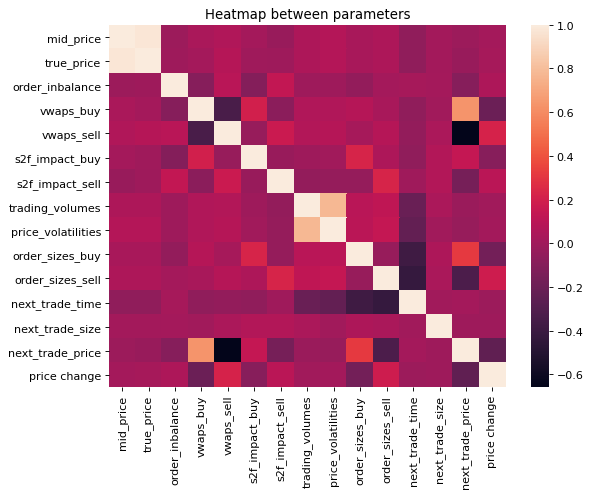

In [30]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.title("Heatmap between parameters")
plt.show()

# models

In [31]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier



In [32]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [33]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
  #  rolled_records = np.roll(records, past, axis = 1)
   # rolled_records = rolled_records[:,past:]
    rolled_records=records[:,:-past] # does the same as above 
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            count_elem = 0.0
            sum_elem = 0.0
            # loop for changing nans to zeros, np.sum(arr) returns nan if nan is in the arr
            for elem in records[day][buck:buck+past]:
                if not math.isnan(elem):
                    sum_elem+=elem
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [34]:
def up_still_down(x, epsilon = 10e-7):
    if x>epsilon:
        return 1
    elif x<-epsilon:
        return -1
    else:
        return 0
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [35]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False

    return res

In [36]:
def get_X(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1, 
                    names=[], 
                   ): # use up_and_down or not 
    ## NEED TO ADD y_name PARAMETER AND USE IT!!!
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]  
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    return X

def get_y(comp_id=1, 
        interval=5, 
        time_to_skip=0, 
        time_back=1, 
        y_name='true_price', 
        check='change',
        swing_interval=30,
         threshold=1e-2):
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
   #??? y = average_smoothing(functions_to_call[y_name](comp_id, interval, time_to_skip), time_back)???
    if check=='change':
        y=functions_to_call['price_change'](y)    
    elif check=='swing_max':
        y=get_y_to_test_max_bool(y, swing_interval, interval, threshold)
    elif check=='swing_min':
        y=get_y_to_test_min_bool(y, swing_interval, interval, threshold)
    else:
        raise ValueError('bad check argument')
    y = y[:,time_back:].flatten()
    return y

In [37]:
def get_X_y_raw(comp_id=1, 
                    interval=5, 
                    time_to_skip=30, 
                    names=[], 
                    y_name='true_price',
                   check_change=False): # use up_and_down or not 
    X = np.empty(shape=(len(names), 10, (510-time_to_skip)//interval))  # parameter, days, timestamps
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')   
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]            
        else:
            raise ValueError('parameter not found')
        X[index]=arr
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    if check_change:
        y=functions_to_call['price_change'](y)    
    
    return X, y

In [38]:
'''
TODO
        #USE REGEX TO CHECK IF STATEMENT
        elif name in ['vwaps_buy', 's2f_impact_buy',   
                      'vwaps_sell', 's2f_impact_sell', 
                      'vwaps_order_sizes_buy', 's2f_order_sizes_buy',
                      'vwaps_order_sizes_sell', 's2f_order_sizes_sell']:
'''

"\nTODO\n        #USE REGEX TO CHECK IF STATEMENT\n        elif name in ['vwaps_buy', 's2f_impact_buy',   \n                      'vwaps_sell', 's2f_impact_sell', \n                      'vwaps_order_sizes_buy', 's2f_order_sizes_buy',\n                      'vwaps_order_sizes_sell', 's2f_order_sizes_sell']:\n"

In [39]:
def get_X_y_averaged(X_raw, y_raw, time_back):
    X_shape=X_raw.shape # parameters, days, timestamps
    X = np.empty(shape=(-X_shape[1]*time_back+X_shape[1]*X_shape[2], X_shape[0]))## we want features as columns, samples as rows
    y=y_raw[:,time_back:].flatten()
    for i in range(X_shape[0]):
        X[:,i]=average_smoothing(X_raw[i], time_back).flatten()
    return X, y

In [40]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [41]:
def logistic_regr(X, y, split_percent, epsilon=1e-6, comp_id=1, 
                               use_scaling=True, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [42]:
def logistic_regr_cross_val(X_train, y_train, X_test, y_test, 
                               use_scaling=True, 
                               local_names=names,
                               track_params=False):
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X_train, y_train)
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0]).T  
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [43]:
def decision_tree(X, y, split_percent, epsilon, comp_id,
                               use_scaling=False, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X[:split], y[:split])
       # print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
    else:
        clf = DecisionTreeClassifier().fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.feature_importances_[i])  
        else:
            print("Coefficient impact:")
          #  print(clf.feature_importances_)
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.feature_importances_[i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("decision tree score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [44]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [45]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0.000001

In [46]:
print(average_comp_price[comp_id])
X=get_X(comp_id, interval, time_to_skip, time_back, names)
y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
print("decision_tree")
print("score: ",decision_tree(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))
print("log reg")
print("score: ",logistic_regr(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))




851.5752484506002
30.520833333333332% of intervals were SELL empty
17.34375% of intervals were BUY empty
1.09375% of intervals were set not filled
decision_tree
Coefficient impact:
order_inbalance   0.15644783541908006
vwaps_buy   0.05484851788598102
vwaps_sell   0.064401870535291
s2f_impact_buy   0.03633856331170606
s2f_impact_sell   0.0755911658771449
trading_volumes   0.1002783265041953
price_volatilities   0.004343611690259336
vwaps_order_sizes_buy   0.009530029289363253
vwaps_order_sizes_sell   0.04168662596497574
s2f_order_sizes_buy   0.0535305117856807
s2f_order_sizes_sell   0.03826696452203967
next_trade_time   0.12818969277884923
next_trade_size   0.14781169061497926
next_trade_price   0.08873459382045427
score:  0.5105263157894737
log reg
Coefficient impact:
order_inbalance   -0.19100459912650092
vwaps_buy   0.4307629082028491
vwaps_sell   0.1083338812499741
s2f_impact_buy   -0.008380857618602173
s2f_impact_sell   0.4932605666921657
trading_volumes   0.3087686681638596
price_

In [47]:
def xgb_cross_val(X_train, y_train, X_test, y_test, use_scaling=True):
    neg_class_count = np.sum(y_train==0)
    pos_class_count = np.sum(y_train==1)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), xgb.XGBClassifier(max_depth=5, scale_pos_weight=neg_class_count/pos_class_count)).fit(X_train, y_train)
    else:
        clf = xgb.XGBClassifier().fit(X_train, y_train)
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0]).T
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [48]:
def dec_tree_cross_val(X_train, y_train, X_test, y_test, use_scaling=True):
    neg_class_count = np.sum(y_train==0)
    pos_class_count = np.sum(y_train==1)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X_train, y_train)
    else:
        clf = DecisionTreeClassifier().fit(X_train, y_train)
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0]).T
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [49]:
def cross_validation(X, y, model, num_of_day = 10, use_scaling = True):
    num_of_samples_in_day = X.shape[0]//num_of_day
    plot_indicators = np.zeros(shape = (10, 3))
    for day in range(num_of_day):
        try:
            X_train = np.concatenate((X[:day*num_of_samples_in_day], X[(day+1)*num_of_samples_in_day:]))
            y_train = np.concatenate((y[:day*num_of_samples_in_day], y[(day+1)*num_of_samples_in_day:]))
            X_test = X[day*num_of_samples_in_day:(day+1)*num_of_samples_in_day]
            y_test = y[day*num_of_samples_in_day:(day+1)*num_of_samples_in_day]
            if model == 'log_reg':
                score, precision, recall = logistic_regr_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling, local_names=names,track_params=False)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
            elif model == 'xgb':
                score, precision, recall = xgb_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
            elif model == 'dec_tree':
                score, precision, recall = dec_tree_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
            elif model == 'MLP':
                score, precision, recall = MLP_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
            elif model == 'LSTM':
                score, precision, recall = LSTM_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
        except ValueError as err:
            plot_indicators[day][0] = math.nan
            plot_indicators[day][1] = math.nan
            plot_indicators[day][2] = math.nan
            print(err)
    return plot_indicators

# Testy modeli na wybranym thresholdzie i porównanie

In [50]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import confusion_matrix

In [51]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]

### Bez skalowania

Mean of all companies for max

In [179]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = False
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [180]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [181]:
print("Average accuracy without scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision without scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall without scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy with scaling:

Logistic regression:	 0.591300097751711
XGB:			 0.5532355816226786
Decision trees:		 0.532492668621701


Average precision without scaling:

Logistic regression:	 0.6154002079250696
XGB:			 0.6110776652910481
Decision trees:		 0.6078344661150065


Average recall without scaling:

Logistic regression:	 0.8418572830182667
XGB:			 0.6730751326290682
Decision trees:		 0.6028211236011415


Mean of all companies for min

In [168]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = False
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [59]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [62]:
print("Average accuracy without scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision without scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall without scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5719061583577715
XGB: 0.5409775171065493
Decision trees: 0.5230498533724339


#### Ze skalowaniem

Mean on all companies for max

In [188]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [189]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [190]:
print("Average accuracy with scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision with scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall with scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy with scaling:

Logistic regression:	 0.5813294232649073
XGB:			 0.5466275659824046
Decision trees:		 0.529364613880743


Average precision with scaling:

Logistic regression:	 0.6128369904339649
XGB:			 0.6139030288409352
Decision trees:		 0.6042927188731502


Average recall with scaling:

Logistic regression:	 0.8139897595520601
XGB:			 0.6376635450294516
Decision trees:		 0.6030514221887602


Mean of all companies for min

In [72]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [73]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [76]:
print("Average accuracy with scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision with scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall with scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5692016943629847
XGB: 0.5349364613880743
Decision trees: 0.52078853046595


### Max z kolejnej godziny patrząc na ostatnie 5 min grupując dane co 5 min

In [169]:
interval=2
time_to_skip=30
time_back=3
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [80]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [176]:
print("Average accuracy with scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision with scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall with scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy with scaling:

Logistic regression:	 0.0
XGB:			 0.0
Decision trees:		 0.0


Average precision without scaling:

Logistic regression:	 0.0
XGB:			 0.0
Decision trees:		 0.0


Average recall without scaling:

Logistic regression:	 0.0
XGB:			 0.0
Decision trees:		 0.0


#### Max z kolejnej godziny patrząc na ostatnie 10 min grupując dane co 5 min

In [86]:
interval=3
time_to_skip=30
time_back=4
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [87]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [90]:
print("Average accuracy with scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision with scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall with scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5817469567469569
XGB: 0.5421004921004922
Decision trees: 0.528885003885004


#### Min z kolejnej godziny patrząc na ostatnie 5 min grupując dane co 5 min

In [85]:
interval=3
time_to_skip=30
time_back=2
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [86]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [89]:
print("Average accuracy with scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision with scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall with scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5399267399267399
XGB: 0.5231879231879234
Decision trees: 0.5124875124875126


### Min z kolejnej godziny patrząc na ostatnie 10 min grupując dane co 5 min

In [92]:
interval=3
time_to_skip=30
time_back=4
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [93]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [96]:
print("Average accuracy with scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision with scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall with scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5285647169368097
XGB: 0.5142706131078223
Decision trees: 0.5104886070002352


### Max z kolejnych 3 godzin patrząc na ostatnie 30 min i biorąc threshold 0.003

In [99]:
interval=3
time_to_skip=30
time_back=10
y_name='true_price'
swing_interval = 180
check = 'swing_max'
use_scaling = True
threshold = 0.003
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [100]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [103]:
print("Average accuracy with scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision with scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall with scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5476767676767677
XGB: 0.5416783216783218
Decision trees: 0.5295493395493394


### Max z kolejnych 3 godzin patrząc na ostatnie 60 min i biorąc threshold 0.003

In [106]:
interval=3
time_to_skip=30
time_back=20
y_name='true_price'
swing_interval = 180
check = 'swing_max'
use_scaling = True
threshold = 0.003
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [107]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [110]:
print("Average accuracy with scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision with scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall with scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5454848484848488
XGB: 0.5497979797979798
Decision trees: 0.5307979797979797


### Min z kolejnych 3 godzin patrząc na ostatnie 30 min i biorąc threshold 0.003

In [113]:
interval=3
time_to_skip=30
time_back=10
y_name='true_price'
swing_interval = 180
check = 'swing_min'
use_scaling = True
threshold = 0.003
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [114]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [117]:
print("Average accuracy with scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision with scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall with scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy without scaling:

Logistic regression: 0.589222999222999
XGB: 0.5771561771561772
Decision trees: 0.5518181818181818


### Min z kolejnych 3 godzin patrząc na ostatnie 60 min i biorąc threshold 0.003

In [120]:
interval=3
time_to_skip=30
time_back=20
y_name='true_price'
swing_interval = 180
check = 'swing_min'
use_scaling = True
threshold = 0.003
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Modele

In [121]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [124]:
print("Average accuracy with scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("\n")
print("Average precision with scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("\n")
print("Average recall with scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)

Average accuracy without scaling:

Logistic regression: 0.580121212121212
XGB: 0.571040404040404
Decision trees: 0.5404040404040403


In [49]:
#!pip install torch
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.8987, 0.9472, 0.8472],
        [0.1437, 0.9774, 0.2603],
        [0.5847, 0.5684, 0.5347],
        [0.0155, 0.8939, 0.1490],
        [0.0452, 0.1147, 0.7835]])


In [91]:
!pip install keras_metrics

In [51]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Dense, Conv1D, MaxPool1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LSTM, GRU
import keras
import keras_metrics

In [52]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [53]:
def prep_data_to_NN(comp_id = 15, interval = 5, time_to_skip = 30, time_back = 1, split_percent = 0.8, threshold = 0.001):
#print(average_comp_price[comp_id])
    X=get_X(comp_id, interval, time_to_skip, time_back, names)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold = threshold)
    end_split = int(split_percent * X.shape[0])
    X_train = X[:end_split]
    y_train = y[:end_split]
    X_test = X[end_split:]
    y_test = y[end_split:]
    print(np.sum(y==1))
    print(y.shape)
    print("decision_tree")
    print("score: ",decision_tree(X, np.copy(y),split_percent, threshold, comp_id, use_scaling=True, local_names=names))
    print("log reg")
    print("score: ",logistic_regr(X, np.copy(y),split_percent, threshold, comp_id, use_scaling=True, local_names=names))
    return X_train, y_train, X_test, y_test


In [54]:
X_train, y_train, X_test, y_test = prep_data_to_NN(comp_id = 56)
y_train_one_hot = tf.one_hot(y_train, depth = 2)
y_test_one_hot = tf.one_hot(y_test, depth = 2)
model = tf.keras.models.Sequential([                    
    #tf.keras.layers.Conv1(filters= 2, kernel_size = 3, activation='tanh', use_bias=False),
    #tf.keras.layers.MaxPool2D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=True, activation="relu", input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1024, use_bias=True, activation="softmax"),
    tf.keras.layers.Dense(512, use_bias=True, activation="softmax"),
    tf.keras.layers.Dense(64, use_bias=True, activation="softmax"),
    tf.keras.layers.Dense(2, use_bias=True, activation="softmax")
  ])

model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy'],
  )

history = model.fit(
      X_train,
      y_train_one_hot,
      validation_split=0.2,
      epochs=90,
      verbose = 1
  )

print("NN score: ")
model.evaluate(X_test, y_test_one_hot, verbose=1)
preds = model.predict(X_test)
move_pred = 0
stay_pred = 0
results = np.zeros(y_test.shape)
correct = 0
for i in range(preds.shape[0]):
    if preds[i][0]>preds[i][1]:
        results[i] = 1
        if y_test[i]==1:
            correct+=1
        move_pred+=1
    else:
        if y_test[i]==0:
            correct+=1
        stay_pred+=1
print("NN score test: ", 
        " move preds: ", move_pred,
        " stay preds: ", stay_pred,
        " accuracy:   ", correct/preds.shape[0]
  )
conf_mat = confusion_matrix(y_test, results, labels = [1, 0]).T
print(conf_mat)
if np.unique(y_test).size>1:
    print("Precision:")
    precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
    print(precision)
    print("Recall:")
    recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
    print(recall)
    print("Accuracy:")
    accuracy = (conf_mat[0][0]+conf_mat[1][1])/results.shape
    print(accuracy)

16.145833333333332% of intervals were SELL empty
25.729166666666668% of intervals were BUY empty
13.385416666666666% of intervals were set not filled
282
(950,)
decision_tree
Coefficient impact:
order_inbalance   0.12979523950251895
vwaps_buy   0.04011556366198471
vwaps_sell   0.12708601722663457
s2f_impact_buy   0.020272685120790366
s2f_impact_sell   0.06287766281881586
trading_volumes   0.10929960986767048
price_volatilities   0.13356369304726062
vwaps_order_sizes_buy   0.009518829950607518
vwaps_order_sizes_sell   0.0858894414790428
s2f_order_sizes_buy   0.026244554170314606
s2f_order_sizes_sell   0.021033588020032024
next_trade_time   0.05174106142276682
next_trade_size   0.0985651256350746
next_trade_price   0.08399692807648612
score:  0.5947368421052631
log reg
Coefficient impact:
order_inbalance   0.6507753997328619
vwaps_buy   0.5251859118816731
vwaps_sell   1.2387949061272636
s2f_impact_buy   -0.2384001642524875
s2f_impact_sell   0.7449987790659041
trading_volumes   0.28389325

NameError: name 'X' is not defined

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


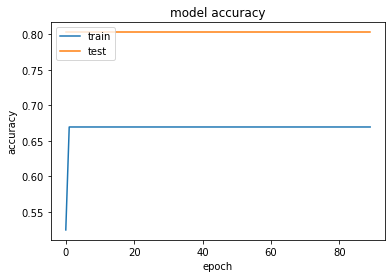

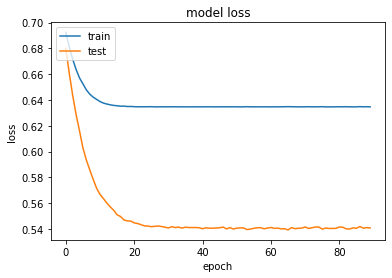

In [166]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Test z plotem loss i accuracy

In [138]:
X_train, y_train, X_test, y_test = prep_data_to_NN(comp_id = 8)
y_train_one_hot = tf.one_hot(y_train, depth = 2)
y_test_one_hot = tf.one_hot(y_test, depth = 2)
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Dense(256, use_bias=True, activation="relu", input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=256, return_sequences=True))
model.add(LSTM(units=128, return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(128))
model.add(Dense(2, activation='softmax'))

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()],
  )

history = model.fit(
      X_train,
      y_train_one_hot,
      validation_split=0.2,
      epochs=150,
      verbose = 1
  )

print("NN score: ")
model.evaluate(X_test, y_test_one_hot, verbose=1)
preds = model.predict(X_test)
move_pred = 0
stay_pred = 0
results = np.zeros(y_test.shape)
correct = 0
for i in range(preds.shape[0]):
    if preds[i][0]>preds[i][1]:
        results[i] = 1
        if y_test[i]==1:
            correct+=1
        move_pred+=1
    else:
        if y_test[i]==0:
            correct+=1
        stay_pred+=1
conf_mat = confusion_matrix(y_test, results, labels = [1, 0]).T
print(conf_mat)
if np.unique(y_test).size>1:
    print("Precision:")
    precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
    print(precision)
    print("Recall:")
    recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
    print(recall)
    print("Accuracy:")
    accuracy = (conf_mat[0][0]+conf_mat[1][1])/results.shape
    print(accuracy)
print(preds)

21.041666666666668% of intervals were SELL empty
25.572916666666668% of intervals were BUY empty
3.5416666666666665% of intervals were set not filled
409
(950,)
decision_tree
Coefficient impact:
order_inbalance   0.13651733667844704
vwaps_buy   0.05849337033890768
vwaps_sell   0.08932067305029302
s2f_impact_buy   0.04217143031767304
s2f_impact_sell   0.09315038479881624
trading_volumes   0.11216592163960247
price_volatilities   0.0
vwaps_order_sizes_buy   0.0559750251118324
vwaps_order_sizes_sell   0.03669289407230815
s2f_order_sizes_buy   0.03565931881562463
s2f_order_sizes_sell   0.01657588228468741
next_trade_time   0.09457228044959735
next_trade_size   0.09469630389549161
next_trade_price   0.13400917854671895
score:  0.3736842105263158
log reg
Coefficient impact:
order_inbalance   -0.4357016554430103
vwaps_buy   0.471227210125895
vwaps_sell   1.0187601968020221
s2f_impact_buy   -0.19830043715590506
s2f_impact_sell   0.31412892442211426
trading_volumes   -0.6267766829681711
price_v

Epoch 42/150
19/19 [==============================] - 2s 97ms/step - loss: 0.6661 - categorical_accuracy: 0.5938 - val_loss: 0.6901 - val_categorical_accuracy: 0.5132
Epoch 43/150
19/19 [==============================] - 2s 98ms/step - loss: 0.6602 - categorical_accuracy: 0.6036 - val_loss: 0.7155 - val_categorical_accuracy: 0.5855
Epoch 44/150
19/19 [==============================] - 2s 99ms/step - loss: 0.6866 - categorical_accuracy: 0.5296 - val_loss: 0.6835 - val_categorical_accuracy: 0.5987
Epoch 45/150
19/19 [==============================] - 2s 98ms/step - loss: 0.6742 - categorical_accuracy: 0.5625 - val_loss: 0.6842 - val_categorical_accuracy: 0.5724
Epoch 46/150
19/19 [==============================] - 2s 98ms/step - loss: 0.6759 - categorical_accuracy: 0.6020 - val_loss: 0.6848 - val_categorical_accuracy: 0.5921
Epoch 47/150
19/19 [==============================] - 2s 99ms/step - loss: 0.6713 - categorical_accuracy: 0.5987 - val_loss: 0.6903 - val_categorical_accuracy: 0.513

Epoch 91/150
19/19 [==============================] - 2s 90ms/step - loss: 0.6614 - categorical_accuracy: 0.5724 - val_loss: 0.6911 - val_categorical_accuracy: 0.4803
Epoch 92/150
19/19 [==============================] - 2s 91ms/step - loss: 0.6477 - categorical_accuracy: 0.5905 - val_loss: 0.6975 - val_categorical_accuracy: 0.4671
Epoch 93/150
19/19 [==============================] - 2s 91ms/step - loss: 0.6465 - categorical_accuracy: 0.6102 - val_loss: 0.7018 - val_categorical_accuracy: 0.5329
Epoch 94/150
19/19 [==============================] - 2s 91ms/step - loss: 0.6438 - categorical_accuracy: 0.6201 - val_loss: 0.7055 - val_categorical_accuracy: 0.5132
Epoch 95/150
19/19 [==============================] - 2s 90ms/step - loss: 0.6411 - categorical_accuracy: 0.6184 - val_loss: 0.6986 - val_categorical_accuracy: 0.5263
Epoch 96/150
19/19 [==============================] - 2s 91ms/step - loss: 0.6487 - categorical_accuracy: 0.6086 - val_loss: 0.6805 - val_categorical_accuracy: 0.598

Epoch 140/150
19/19 [==============================] - 2s 89ms/step - loss: 0.6012 - categorical_accuracy: 0.6562 - val_loss: 0.8191 - val_categorical_accuracy: 0.4868
Epoch 141/150
19/19 [==============================] - 2s 99ms/step - loss: 0.6059 - categorical_accuracy: 0.6168 - val_loss: 0.8559 - val_categorical_accuracy: 0.5000
Epoch 142/150
19/19 [==============================] - 2s 99ms/step - loss: 0.6081 - categorical_accuracy: 0.6776 - val_loss: 0.8029 - val_categorical_accuracy: 0.5658
Epoch 143/150
19/19 [==============================] - 2s 95ms/step - loss: 0.6218 - categorical_accuracy: 0.6332 - val_loss: 0.7907 - val_categorical_accuracy: 0.5000
Epoch 144/150
19/19 [==============================] - 2s 95ms/step - loss: 0.6275 - categorical_accuracy: 0.6365 - val_loss: 0.7309 - val_categorical_accuracy: 0.5461
Epoch 145/150
19/19 [==============================] - 2s 94ms/step - loss: 0.6151 - categorical_accuracy: 0.6595 - val_loss: 0.7790 - val_categorical_accuracy:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


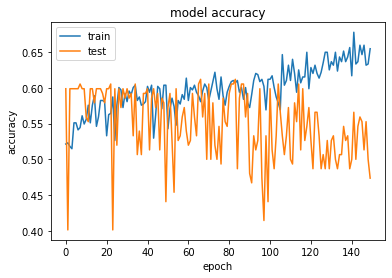

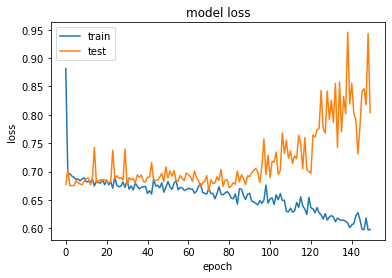

In [139]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
def MLP_cross_val(X_train, y_train, X_test, y_test, use_scaling=True):
    y_train_one_hot = tf.one_hot(y_train, depth = 2)
    y_test_one_hot = tf.one_hot(y_test, depth = 2)
    neg_class_count = np.sum(y_train==0)
    pos_class_count = np.sum(y_train==1)
    
    model = tf.keras.models.Sequential([                    
    #tf.keras.layers.Conv1(filters= 2, kernel_size = 3, activation='tanh', use_bias=False),
    #tf.keras.layers.MaxPool2D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=True, activation="relu", input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1024, use_bias=True, activation="softmax"),
    tf.keras.layers.Dense(64, use_bias=True, activation="softmax"),
    tf.keras.layers.Dense(2, use_bias=True, activation="softmax")
  ])

    model.compile(
          optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['categorical_accuracy'],
      )

    history = model.fit(
          X_train,
          y_train_one_hot,
          validation_split=0.2,
          epochs=200,
          verbose = 0
      )

    print("NN score: ")
    model.evaluate(X_test, y_test_one_hot, verbose=1)
    preds = model.predict(X_test)
    move_pred = 0
    stay_pred = 0
    results = np.zeros(y_test.shape)
    correct = 0
    for i in range(preds.shape[0]):
        if preds[i][0]>preds[i][1]:
            results[i] = 1
            if y_test[i]==1:
                correct+=1
            move_pred+=1
        else:
            if y_test[i]==0:
                correct+=1
            stay_pred+=1
    print("NN score test: ", 
            " move preds: ", move_pred,
            " stay preds: ", stay_pred,
            " accuracy:   ", correct/preds.shape[0]
      )
    conf_mat = confusion_matrix(y_test, results, labels = [1, 0]).T
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
        print("Accuracy:")
        accuracy = (conf_mat[0][0]+conf_mat[1][1])/results.shape
        print(accuracy)
        return accuracy, precision, recall
    else:
        return accuracy, math.nan, math.nan

In [68]:
def LSTM_cross_val(X_train, y_train, X_test, y_test, use_scaling=True):
    y_train_one_hot = tf.one_hot(y_train, depth = 2)
    y_test_one_hot = tf.one_hot(y_test, depth = 2)
    neg_class_count = np.sum(y_train==0)
    pos_class_count = np.sum(y_train==1)
    
    model = keras.Sequential()
    # Add an Embedding layer expecting input vocab of size 1000, and
    # output embedding dimension of size 64.
    model.add(layers.Dense(256, use_bias=True, activation="relu", input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=256, return_sequences=True))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dense(128))
    model.add(Dense(2, activation='softmax'))

    model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
          loss=tf.keras.losses.CategoricalCrossentropy(),
          metrics=[tf.keras.metrics.CategoricalAccuracy()],
      )

    history = model.fit(
          X_train,
          y_train_one_hot,
          validation_split=0.2,
          epochs=200,
          verbose = 0
      )

    print("NN score: ")
    model.evaluate(X_test, y_test_one_hot, verbose=1)
    preds = model.predict(X_test)
    move_pred = 0
    stay_pred = 0
    results = np.zeros(y_test.shape)
    correct = 0
    for i in range(preds.shape[0]):
        if preds[i][0]>preds[i][1]:
            results[i] = 1
            if y_test[i]==1:
                correct+=1
            move_pred+=1
        else:
            if y_test[i]==0:
                correct+=1
            stay_pred+=1
    print("NN score test: ", 
            " move preds: ", move_pred,
            " stay preds: ", stay_pred,
            " accuracy:   ", correct/preds.shape[0]
      )
    conf_mat = confusion_matrix(y_test, results, labels = [1, 0]).T
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
        print("Accuracy:")
        accuracy = (conf_mat[0][0]+conf_mat[1][1])/results.shape
        print(accuracy)
        return accuracy, precision, recall
    else:
        return accuracy, math.nan, math.nan

In [69]:
interval=2
time_to_skip=30
time_back=3
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0
sum_of_acc_mlp = 0.0
sum_of_prec_mlp = 0.0
sum_of_recall_mlp = 0.0
sum_of_acc_lstm = 0.0
sum_of_prec_lstm = 0.0
sum_of_recall_lstm = 0.0

In [70]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    #MLP_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'LSTM',use_scaling = use_scaling)
    sum_of_acc_lstm+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_lstm += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_lstm += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #MLP_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'MLP',use_scaling = use_scaling)
    sum_of_acc_mlp+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_mlp += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_mlp += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Log reg test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #Dec tree test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    #XGB_test
    res_per_day = cross_validation(np.copy(X), np.copy(y), 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

comp_id = 4
28.270833333333332% of intervals were SELL empty
27.729166666666668% of intervals were BUY empty
0.125% of intervals were set not filled


<ipython-input-35-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


NN score: 
8/8 [==============================] - 0s 35ms/step - loss: 0.9982 - categorical_accuracy: 0.5865
NN score test:   move preds:  100  stay preds:  137  accuracy:    0.41350210970464135
[[41 59]
 [80 57]]
Precision:
0.41
Recall:
0.33884297520661155
Accuracy:
[0.41350211]


KeyboardInterrupt: 

In [71]:
print("Average accuracy with scaling:\n")
print("Logistic regression:\t",sum_of_acc_log_reg/99)
print("XGB:\t\t\t",sum_of_acc_xgb/99)
print("Decision trees:\t\t",sum_of_acc_tree/99)
print("MLP:\t\t\t",sum_of_acc_mlp/99)
print("LSTM:\t\t\t",sum_of_acc_lstm/99)
print("\n")
print("Average precision with scaling:\n")
print("Logistic regression:\t",sum_of_prec_log_reg/99)
print("XGB:\t\t\t",sum_of_prec_xgb/99)
print("Decision trees:\t\t",sum_of_prec_tree/99)
print("MLP:\t\t\t",sum_of_prec_mlp/99)
print("LSTM:\t\t\t",sum_of_prec_lstm/99)
print("\n")
print("Average recall with scaling:\n")
print("Logistic regression:\t",sum_of_recall_log_reg/99)
print("XGB:\t\t\t",sum_of_recall_xgb/99)
print("Decision trees:\t\t",sum_of_recall_tree/99)
print("MLP:\t\t\t",sum_of_recall_mlp/99)
print("LSTM:\t\t\t",sum_of_recall_lstm/99)

Average accuracy with scaling:

Logistic regression:	 0.024510932105868816
XGB:			 0.02233303499126284
Decision trees:		 0.0215914418446064
MLP:			 0.015155777181093639
LSTM:			 0.016319311256020114


Average precision with scaling:

Logistic regression:	 0.025303723899015224
XGB:			 0.025795462468175854
Decision trees:		 0.02551182232168675
MLP:			 nan
LSTM:			 nan


Average recall with scaling:

Logistic regression:	 0.037333638796603216
XGB:			 0.026424843996695247
Decision trees:		 0.025051181661944196
MLP:			 0.0
LSTM:			 0.002749071937367391


### Interval

In [62]:
time_to_skip=30
time_back=3
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0

In [63]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]

In [69]:
interval_plot = np.zeros((3,20))
for i in range(1,21,1):
    sum_of_acc_log_reg = 0.0
    sum_of_prec_log_reg = 0.0
    count_prec = 0
    sum_of_recall_log_reg = 0.0
    interval=i
    for comp_id in range(99):
        print("comp_id =",comp_id)
        X = get_X(comp_id, interval, time_to_skip, time_back, names)
        y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
        #Log reg test
        res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
        sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
        mom = np.sum(res_per_day[:,1])/res_per_day.shape[0]
        if math.isnan(mom):
            continue
        else:
            sum_of_prec_log_reg += mom
            count_prec+=1
        sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
        clear_output(wait=True)
    clear_output(wait=True)
    interval_plot[0,i-1] = sum_of_acc_log_reg/99
    if count_prec>75:
        interval_plot[1,i-1] = sum_of_prec_log_reg/count_prec
    else:
        interval_plot[1,i-1] = math.nan
    interval_plot[2,i-1] = sum_of_recall_log_reg/99

comp_id = 88
13.333333333333334% of intervals were SELL empty
23.75% of intervals were BUY empty
6.25% of intervals were set not filled
Coefficient impact:
order_inbalance   0.4672891275498991
vwaps_buy   0.6742002398365814
vwaps_sell   0.5489888864470314
s2f_impact_buy   -0.24626232409122523
s2f_impact_sell   0.15840338785136016
trading_volumes   -1.1734834920838484
price_volatilities   0.33706318102561134
vwaps_order_sizes_buy   -0.358146806913376
vwaps_order_sizes_sell   0.20988172998443988
s2f_order_sizes_buy   -0.358146806913376
s2f_order_sizes_sell   0.20988172998443988
next_trade_time   0.7021657789189786
next_trade_size   -0.38960256277287597
next_trade_price   -0.7095936555942826
Number of positive class in training dataset = 63
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 11
Number of negative class in testing dataset = 10
Percent of correct classification:
0.47619047619047616
Confusion matrix:
[[ 0  0]
 [11 10]]
Precision:


<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])


Coefficient impact:
order_inbalance   0.5572447039496011
vwaps_buy   -0.3623404631236634
vwaps_sell   0.1579004980075234
s2f_impact_buy   0.4162941025451937
s2f_impact_sell   0.8468243202828315
trading_volumes   0.06958980095513279
price_volatilities   0.35832064567253813
vwaps_order_sizes_buy   0.49193474987787056
vwaps_order_sizes_sell   -0.11566980377476359
s2f_order_sizes_buy   0.49193474987787056
s2f_order_sizes_sell   -0.11566980377476359
next_trade_time   -0.07433395278521848
next_trade_size   0.19550713213688034
next_trade_price   -0.19033582624562073
Number of positive class in training dataset = 61
Number of negative class in training dataset = 128
Number of positive class in testing dataset = 11
Number of negative class in testing dataset = 10
Percent of correct classification:
0.42857142857142855
Confusion matrix:
[[ 1  2]
 [10  8]]
Precision:
0.3333333333333333
Recall:
0.09090909090909091
Coefficient impact:
order_inbalance   0.6911115860535338
vwaps_buy   -0.5477596823449

<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])


Coefficient impact:
order_inbalance   -0.6892602389859153
vwaps_buy   0.27375137394283416
vwaps_sell   0.22493635122317893
s2f_impact_buy   -0.1713209548231246
s2f_impact_sell   -0.375665259457986
trading_volumes   0.07004698643308838
price_volatilities   0.6765949076115053
vwaps_order_sizes_buy   -0.8473383241419482
vwaps_order_sizes_sell   -0.07142962085480986
s2f_order_sizes_buy   -0.8473383241419482
s2f_order_sizes_sell   -0.07142962085480986
next_trade_time   -0.46203583724466346
next_trade_size   -0.48223363586043383
next_trade_price   0.5715368758542356
Number of positive class in training dataset = 69
Number of negative class in training dataset = 120
Number of positive class in testing dataset = 10
Number of negative class in testing dataset = 11
Percent of correct classification:
0.47619047619047616
Confusion matrix:
[[ 0  1]
 [10 10]]
Precision:
0.0
Recall:
0.0
Coefficient impact:
order_inbalance   -0.4322603867976004
vwaps_buy   0.1347826138860108
vwaps_sell   -0.1692210780

<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])


Coefficient impact:
order_inbalance   -0.2919564629976739
vwaps_buy   -0.13552500001242523
vwaps_sell   0.22531388040185815
s2f_impact_buy   -0.7010832369357126
s2f_impact_sell   0.0023216759766658593
trading_volumes   -0.2634227239563555
price_volatilities   -0.3079883207818407
vwaps_order_sizes_buy   -0.10023371122202326
vwaps_order_sizes_sell   0.17414657814724177
s2f_order_sizes_buy   -0.10023371122202326
s2f_order_sizes_sell   0.17414657814724177
next_trade_time   -0.3683553937024857
next_trade_size   0.9408362677893173
next_trade_price   -0.26170966423036907
Number of positive class in training dataset = 84
Number of negative class in training dataset = 105
Number of positive class in testing dataset = 10
Number of negative class in testing dataset = 11
Percent of correct classification:
0.5238095238095238
Confusion matrix:
[[ 0  0]
 [10 11]]
Precision:
nan
Recall:
0.0
Coefficient impact:
order_inbalance   -0.07820939747380086
vwaps_buy   -0.11336599753335758
vwaps_sell   0.41142

<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])


Coefficient impact:
order_inbalance   0.12397733217494414
vwaps_buy   0.4865083340445687
vwaps_sell   0.8900717463570144
s2f_impact_buy   0.7828424859370716
s2f_impact_sell   0.06027868212813211
trading_volumes   0.30778181430572416
price_volatilities   0.5149724813052627
vwaps_order_sizes_buy   0.3330793404084052
vwaps_order_sizes_sell   -0.19647907727603214
s2f_order_sizes_buy   0.3330793404084052
s2f_order_sizes_sell   -0.19647907727603214
next_trade_time   -0.0020323546157930868
next_trade_size   -0.6590206740899163
next_trade_price   -0.3162650746776689
Number of positive class in training dataset = 70
Number of negative class in training dataset = 119
Number of positive class in testing dataset = 14
Number of negative class in testing dataset = 7
Percent of correct classification:
0.3333333333333333
Confusion matrix:
[[ 1  1]
 [13  6]]
Precision:
0.5
Recall:
0.07142857142857142
Coefficient impact:
order_inbalance   0.3244546819812619
vwaps_buy   0.3976890454034564
vwaps_sell   0.

<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])


Coefficient impact:
order_inbalance   -0.717441753254642
vwaps_buy   0.677412046999909
vwaps_sell   0.8377225259539719
s2f_impact_buy   0.03472509751097762
s2f_impact_sell   0.16235459656326043
trading_volumes   0.37688735459289135
price_volatilities   -0.016421951547839486
vwaps_order_sizes_buy   -0.15260961315350444
vwaps_order_sizes_sell   -0.019557177420680777
s2f_order_sizes_buy   -0.15260961315350444
s2f_order_sizes_sell   -0.019557177420680777
next_trade_time   0.2059159452711124
next_trade_size   1.4681934879843592
next_trade_price   -0.16767380636611873
Number of positive class in training dataset = 75
Number of negative class in training dataset = 114
Number of positive class in testing dataset = 10
Number of negative class in testing dataset = 11
Percent of correct classification:
0.6666666666666666
Confusion matrix:
[[ 3  0]
 [ 7 11]]
Precision:
1.0
Recall:
0.3
Coefficient impact:
order_inbalance   -0.8556232510831409
vwaps_buy   0.1857950153977914
vwaps_sell   0.7227903062

<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])


Coefficient impact:
order_inbalance   0.11562212462630504
vwaps_buy   0.6916564792040982
vwaps_sell   1.1242534825496027
s2f_impact_buy   0.47310473280474974
s2f_impact_sell   -0.31163719089828673
trading_volumes   -0.29898393620595265
price_volatilities   -0.589910589417633
vwaps_order_sizes_buy   0.33967571344117653
vwaps_order_sizes_sell   -0.26824495142645005
s2f_order_sizes_buy   0.33967571344117653
s2f_order_sizes_sell   -0.26824495142645005
next_trade_time   -0.4212625110303545
next_trade_size   -0.5665285273361229
next_trade_price   -0.5138788303738987
Number of positive class in training dataset = 62
Number of negative class in training dataset = 127
Number of positive class in testing dataset = 9
Number of negative class in testing dataset = 12
Percent of correct classification:
0.5714285714285714
Confusion matrix:
[[ 0  0]
 [ 9 12]]
Precision:
nan
Recall:
0.0
Coefficient impact:
order_inbalance   0.4109007675526579
vwaps_buy   0.3969499706260621
vwaps_sell   0.97926076083136

<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWar

15.416666666666666% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
31.666666666666668% of intervals were set not filled
Coefficient impact:
order_inbalance   -0.05699088804880525
vwaps_buy   0.3076491478849349
vwaps_sell   -0.3156280325111511
s2f_impact_buy   -0.5971324377621867
s2f_impact_sell   -0.2695138352943609
trading_volumes   -0.407622511669953
price_volatilities   -0.9696887202227444
vwaps_order_sizes_buy   0.09331571688518274
vwaps_order_sizes_sell   0.5372847152904917
s2f_order_sizes_buy   0.09331571688518274
s2f_order_sizes_sell   0.5372847152904917
next_trade_time   0.10610567106940375
next_trade_size   -0.786611328766421
next_trade_price   0.3985585129210993
Number of positive class in training dataset = 91
Number of negative class in training dataset = 98
Number of positive class in testing dataset = 13
Number of negative class in testing dataset = 8
Percent of correct classification:
0.3333333333333333
Confusion matrix:
[[6 7]
 [7 1]]
Preci

<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])


Coefficient impact:
order_inbalance   -0.5916542398170747
vwaps_buy   -0.5423712711879025
vwaps_sell   -0.5089030284639662
s2f_impact_buy   0.4992712626743124
s2f_impact_sell   -0.6134600686632413
trading_volumes   -0.42851763473021004
price_volatilities   0.13201025867299154
vwaps_order_sizes_buy   0.30804853517850284
vwaps_order_sizes_sell   0.18889124477430272
s2f_order_sizes_buy   0.30804853517850284
s2f_order_sizes_sell   0.18889124477430272
next_trade_time   0.6243463276754728
next_trade_size   -0.3593750296968658
next_trade_price   -0.17074037159083102
Number of positive class in training dataset = 64
Number of negative class in training dataset = 125
Number of positive class in testing dataset = 8
Number of negative class in testing dataset = 13
Percent of correct classification:
0.6190476190476191
Confusion matrix:
[[ 0  0]
 [ 8 13]]
Precision:
nan
Recall:
0.0
Coefficient impact:
order_inbalance   -0.6539422436893494
vwaps_buy   -0.5914981208763659
vwaps_sell   -0.710014868826

<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWar

Coefficient impact:
order_inbalance   -0.07637348090495918
vwaps_buy   -0.6008737448501319
vwaps_sell   -0.3433234620927823
s2f_impact_buy   0.39623100936252603
s2f_impact_sell   -0.3300071777060308
trading_volumes   0.44123875862499506
price_volatilities   -0.4740018121040556
vwaps_order_sizes_buy   -0.20985664253037561
vwaps_order_sizes_sell   -0.22046983416878854
s2f_order_sizes_buy   -0.20985664253037561
s2f_order_sizes_sell   -0.22046983416878854
next_trade_time   0.7999479037847697
next_trade_size   0.8829959330828958
next_trade_price   0.0068423961523934075
Number of positive class in training dataset = 73
Number of negative class in training dataset = 116
Number of positive class in testing dataset = 12
Number of negative class in testing dataset = 9
Percent of correct classification:
0.42857142857142855
Confusion matrix:
[[ 0  0]
 [12  9]]
Precision:
nan
Recall:
0.0
Coefficient impact:
order_inbalance   -0.43876472930470367
vwaps_buy   -0.5622085747808112
vwaps_sell   -0.64030

<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])


Coefficient impact:
order_inbalance   -0.9012264112088719
vwaps_buy   0.4117856632379845
vwaps_sell   0.28148998838118783
s2f_impact_buy   -0.36793852825701073
s2f_impact_sell   -0.5647147582859801
trading_volumes   0.5350375377751669
price_volatilities   0.2008772257910559
vwaps_order_sizes_buy   0.10158253952794005
vwaps_order_sizes_sell   -0.131336023507291
s2f_order_sizes_buy   0.10158253952794005
s2f_order_sizes_sell   -0.131336023507291
next_trade_time   0.4684353465926123
next_trade_size   1.0514717230851547
next_trade_price   0.2695274470257085
Number of positive class in training dataset = 67
Number of negative class in training dataset = 122
Number of positive class in testing dataset = 7
Number of negative class in testing dataset = 14
Percent of correct classification:
0.5238095238095238
Confusion matrix:
[[ 0  3]
 [ 7 11]]
Precision:
0.0
Recall:
0.0
Coefficient impact:
order_inbalance   -0.8031352601026578
vwaps_buy   0.09015261272634473
vwaps_sell   0.266153123675288
s2f_

<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
<ipython-input-42-d55df71d8dba>:36: RuntimeWar

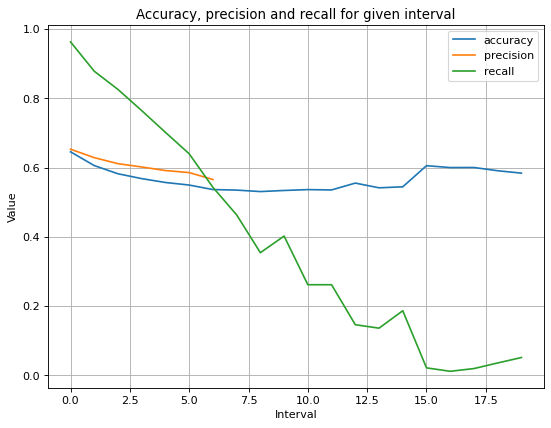

In [70]:
figure(figsize=(8, 6), dpi=80)
labels = ["accuracy","precision","recall"]
for i in range(3):
    plt.plot(interval_plot[i,])
plt.grid()
plt.title("Accuracy, precision and recall for given interval")
plt.xlabel("Interval")
plt.ylabel("Value")
plt.legend(labels)

In [71]:
interval_plot

array([[0.64561125, 0.60585603, 0.58223638, 0.56822067, 0.55705442,
        0.54966549, 0.53664336, 0.53507   , 0.53084848, 0.53400673,
        0.53651515, 0.53551734, 0.55531068, 0.54167481, 0.54454894,
        0.60557426, 0.60012121, 0.60035134, 0.590955  , 0.58407888],
       [0.65321411, 0.62872819, 0.61137998, 0.60182174, 0.59154061,
        0.5856362 , 0.56574429,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [0.96306058, 0.8782755 , 0.82560647, 0.76452783, 0.70172084,
        0.63993591, 0.54311467, 0.46355026, 0.35442704, 0.40238256,
        0.26191109, 0.26188216, 0.14644651, 0.13652176, 0.18679932,
        0.02190759, 0.01196123, 0.01987166, 0.03606905, 0.05173854]])

### Threshold

In [ ]:
interval = 1
time_to_skip=30
time_back=3
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0

In [ ]:
thresholds = np.geomspace(1e-2, 1e-9, num = 8)
thresholds

In [ ]:
threshold_plot = np.zeros((3,8))
thresholds = np.geomspace(1e-2, 1e-9, num = 8)
for i in range(0,8,1):
    threshold = thresholds[i]
    for comp_id in range(99):
        print("comp_id =",comp_id)
        X = get_X(comp_id, interval, time_to_skip, time_back, names)
        y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
        #Log reg test
        res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
        sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
        sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
        sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
        clear_output(wait=True)
    clear_output(wait=True)
    threshold_plot[0,i-1] = sum_of_acc_log_reg/99
    threshold_plot[1,i-1] = sum_of_prec_log_reg/99
    threshold_plot[2,i-1] = sum_of_recall_log_reg/99

In [ ]:
figure(figsize=(8, 6), dpi=80)
labels = ["accuracy","precision","recall"]
for i in range(3):
    plt.plot(threshold_plot[i,])
plt.grid()
plt.title("Accuracy, precision and recall")
plt.xlabel("Thresholds")
plt.ylabel("Value")
plt.legend(labels)

### Time_back

In [56]:
interval = 1
time_to_skip=30
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
threshold = 0.001

In [57]:
timeback_plot = np.zeros((3,20))
for i in range(1,21,1):
    sum_of_acc_log_reg = 0.0
    sum_of_prec_log_reg = 0.0
    sum_of_recall_log_reg = 0.0
    time_back=i
    for comp_id in range(99):
        print("comp_id =",comp_id)
        X = get_X(comp_id, interval, time_to_skip, time_back, names)
        y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
        #Log reg test
        res_per_day = cross_validation(np.copy(X), np.copy(y), 'log_reg',use_scaling = use_scaling)
        sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
        sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
        sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
        clear_output(wait=True)
    clear_output(wait=True)
    timeback_plot[0,i-1] = sum_of_acc_log_reg/99
    timeback_plot[1,i-1] = sum_of_prec_log_reg/99
    timeback_plot[2,i-1] = sum_of_recall_log_reg/99

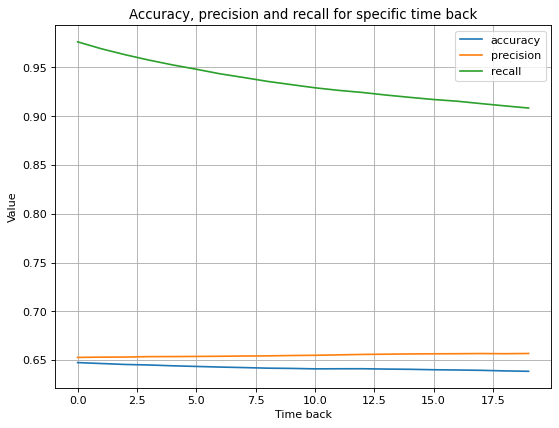

In [60]:
figure(figsize=(8, 6), dpi=80)
labels = ["accuracy","precision","recall"]
for i in range(3):
    plt.plot(timeback_plot[i,])
plt.grid()
plt.title("Accuracy, precision and recall for specific time back")
plt.xlabel("Time back")
plt.ylabel("Value")
plt.legend(labels)